# IFRS9 portfolio analytics

In this notebook I aim to provide a practical implementation to address daily credit portfolio monitoring needs, in particular to track and explain **expected credit losses per IFRS 9 standard**, perform vintage analysis, drill-down to loan-level data, analyze changes between periods and determine main drivers behind the portfolio risk KPIs.

I hope this example can serve as inspiration for your work in the IFRS field.

As a quick reminder, as a result of the Great Financial Crisis of 2008, the accounting standards were redesigned, which culminated with the International Financial Reporting Standard number 9 (IFRS 9) and Current Expected Credit Loss (CECL). They key innovation of the new standard was the requirement to recognize in financial statements not only the incurred losses for a credit portfolio, but compute a forward looking measure - expected credit losses for a portfolio.

By common practice, the expected credit losses computation relies on the three ingredients: probability of default (PD), loss given default (LGD), and exposure at default (EAD) framework and the three stage classification. Continue reading to learn how loan-level credit risk data can be consolidated in an analytical app - IFRS 9 app - enriched with static attributes and analized interactively in the UI.

<img src=./ifrs9-app.png/ width = 70%>

We'll start by creating an atoti app, then we'll load sample data and implement chains of calculations for ECL and other analytical measures.

# Launch atoti

Let's create an atoti session to launch the aggregation engine and the UI.

In [1]:
import atoti as tt

config = tt.config.create_config(metadata_db="./metadata.db", max_memory="8G")
session = tt.create_session(config=config)
session.url

Welcome to atoti 0.5.1!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


'http://localhost:56221'

## Input Data overview

In this section we will load the data used by the ECL calculation into in-memory datastores. 

The sample data will be fetched from csv files hosted on s3, and you can replace them with your own sources.

I’ve created a sample data set based on the [Lending Club dataset available on Kaggle](https://www.kaggle.com/janiobachmann/datasets) and mocked-up the risk engine outputs - PDs, LGDs, EADs and stages - to illustrate how the IFRS 9 metrics can be computed and visualized in an analytical app. 

We'll use these three datastores:

- `risk_engine_data` keeps information on the individual loans, their explosures, stages, credit risk parameters for ECL calculation and other attributes by date,
- `lending_club_data` keeps additional data - client attributes, such as rating and sector,
- `loans_at_inception` is storing loan opening information, such as opening date and opening risk characteristics. 

### Credit Risk Engine Inputs

In [2]:
# install atoti-aws extention to load reference data from s3
!conda install atoti-aws -y

Solving environment: done

# All requested packages already installed.



In [3]:
# src = "s3://data.atoti.io/notebooks/ifrs9/"

In [4]:
risk_engine_data = session.read_csv(
    "lending-club-data/risk-engine/",
    keys=["Reporting Date", "id"],
    store_name="Credit Risk",
    types={
        "EAD": tt.type.NULLABLE_DOUBLE,
        "Stage": tt.type.NULLABLE_INT,
        "Previous Stage": tt.type.NULLABLE_INT,
    },
)
risk_engine_data.head(3)

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


PD12      PDLT          EAD  LGD  Stage  \
Reporting Date id                                                   
2008-05-01     87023  0.336538  0.403845  8653.944595  0.8      2   
               88637  0.051744  0.062093  6923.155676  0.8      2   
               88046  0.022850  0.027419  5076.980829  0.8      1   

                      Previous PD12  Previous PDLT  Previous EAD  \
Reporting Date id                                                  
2008-05-01     87023       0.336698       0.404037   8610.741713   
               88637       0.056647       0.067977   6888.593370   
               88046       0.023674       0.028409   5051.635138   

                      Previous LGD  Previous Stage  DaysPastDue  
Reporting Date id                                                
2008-05-01     87023          0.81               2          NaN  
               88637          0.81               2          NaN  
               88046          0.81               1          NaN

### Creating a cube

As a next step, I'm creating the cube.

In [5]:
cube = session.create_cube(risk_engine_data, "IFRS9")

### Adding LendingClub data

The [LendingClub](https://en.wikipedia.org/wiki/LendingClub) data I'm using for illustrative purposes can be downloaded from: [Janio Martinez Bachmann on Kaggle](https://www.kaggle.com/janiobachmann/datasets). Here's a description of the dataset and field description: [A Hitchhiker's Guide to Lending Club Loan Data
](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data).

In [6]:
lending_club_data = session.read_csv(
    "lending-club-data/loans.csv",
    keys=["id"],
    store_name="Lending Club Data",
)
risk_engine_data.join(lending_club_data)
lending_club_data.head(3)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,issue_date,maturity_date,loan_class,Opening Year,Opening Month,Opening Day
id,,,,,,,,,,,,,,,,,,,,,
849780,1061523,10000.0,10000.0,10000.0,36 months,10.99,327.34,B,B3,Department of Defense,...,N/A,N/A,N/A,N/A,2011-01-08,2014-08-01,0.0,2011,8,1
849784,1061526,6500.0,6500.0,6500.0,36 months,7.49,202.17,A,A4,City of Dearborn Heights,...,N/A,N/A,N/A,N/A,2011-01-08,2014-08-01,0.0,2011,8,1
849748,1061487,7000.0,7000.0,7000.0,36 months,6.99,216.11,A,A3,Schneider Electric,...,N/A,N/A,N/A,N/A,2011-01-08,2014-08-01,0.0,2011,8,1


See later how to create measures aggregating Lending Club data.

### Adding loans opening parameters

In [7]:
loans_at_inception = session.read_csv(
    "lending-club-data/static.csv",
    keys=["id"],
    store_name="Parameters at inception",
)
loans_at_inception.head(3)

,default_date,Opening PD12,Opening PDLT
id,,,
1077501,N/A,0.041374,0.049649
1077430,2012-09-06 00:00:00,0.089122,0.106946
1077175,N/A,0.097341,0.116809


In [8]:
# Linking contracts and their opening information
risk_engine_data.join(loans_at_inception)

### Cube schema

Based on the datastores we've loaded and linked together, this is the view of our current cube schema.

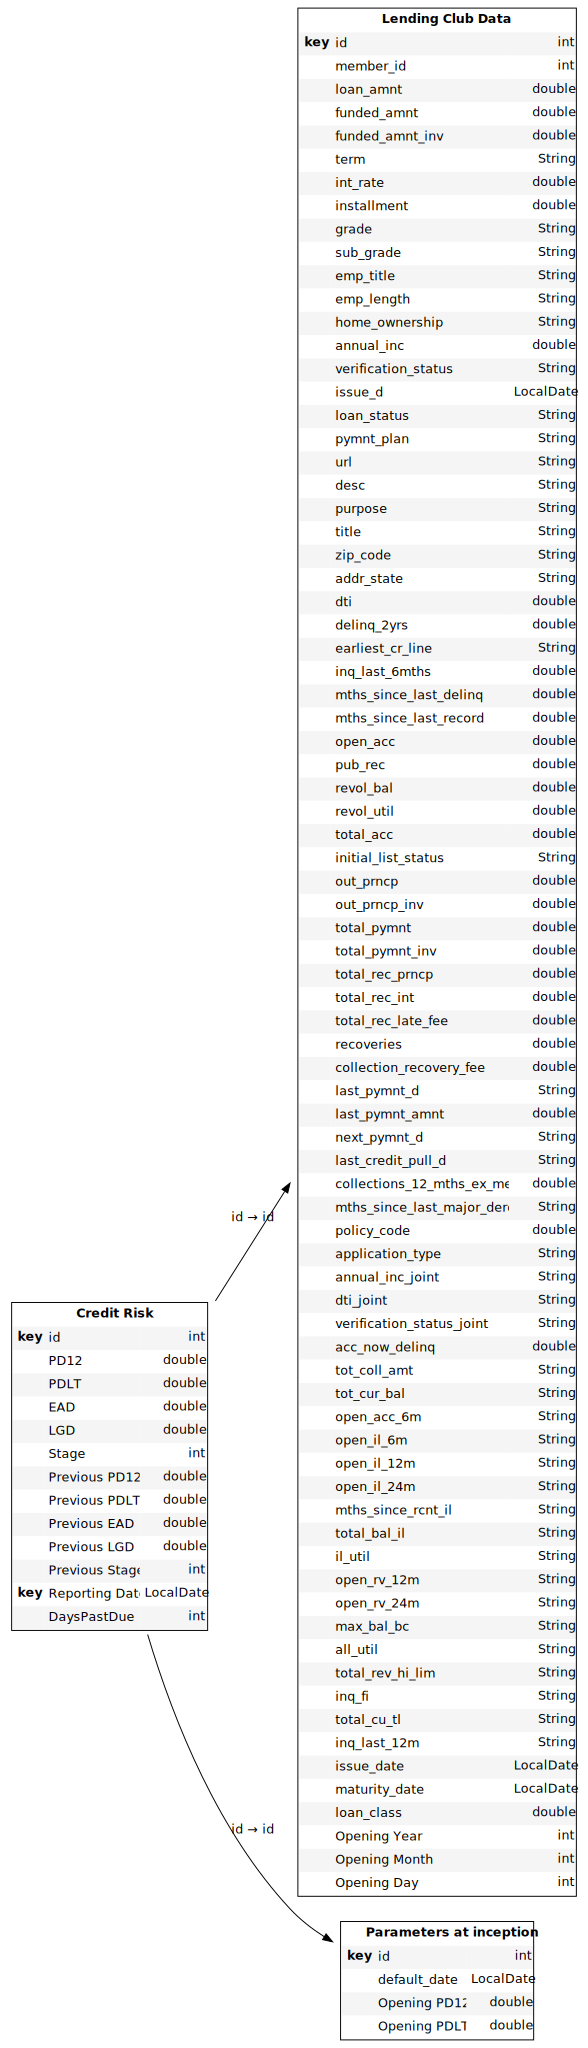

In [9]:
cube.schema

# Getting started with cube configuration

In this section I'm demonstrating some of the typical actions that you can apply to your newly created cube.

In [10]:
# These are the variables for faster access to the cube data elements:
l = cube.levels
m = cube.measures
h = cube.hierarchies

In [11]:
# Setting a dimension to slicing will prevent measures to aggregate risk coming from different members of that dimension:
h["Reporting Date"].slicing = True

In [12]:
# By setting the sort on the reporting date to DESC, we make sure that the latest date appears by default.
l["Reporting Date"].comparator = tt.comparator.DESC

In [13]:
# Multi-level hierarchies come handy when you have a typical way to expand data:
h["Opening Date (detailed)"] = {
    "Year": lending_club_data["Opening Year"],
    "Month": lending_club_data["Opening Month"],
    "Day": lending_club_data["Opening Day"],
}

# Measures visualizing credit risk inputs

In this section you will find various measures that we create to visualize risk engine output in the UI. 

## Stages and their variations

In this section, we define measures to visualize Stages and their variations.

As a reminder, **Impairment** of financial assets is recognised in stages:

- **Stage 1** Low credit risk or no increase since initial recognition: one-year ECL
- **Stage 2** If the credit risk increases significantly and is not considered low: lifetime ECL 
- **Stage 3** impaired assets

In [14]:
m["Stage"] = tt.value(risk_engine_data["Stage"])
m["Stage"].folder = "Stage"

# This is how we can create measures to display the previous value and daily changes side by side with the value:
m["Previous Stage"] = tt.shift(m["Stage"], on=l["Reporting Date"], offset=1)
m["Previous Stage"].folder = "Stage"

m["Stage Variation"] = tt.where(
    m["Previous Stage"] != None, m["Stage"] - m["Previous Stage"]
)
m["Stage Variation"].folder = "Stage"
m["Stage Variation"].formatter = "DOUBLE[+#,###;-#,###]"

## EAD aggregation

The **Exposure At Default** is the estimated amount of loss a bank may be exposed to when a debtor defaults on a loan.

In [15]:
m["EAD"] = tt.agg.sum(risk_engine_data["EAD"])
m["EAD"].folder = "EAD"

# This is how we can create measures to display the previous value and daily changes side by side with the value:
m["Previous EAD"] = tt.shift(m["EAD"], on=l["Reporting Date"], offset=1)
m["Previous EAD"].folder = "EAD"

m["EAD (Chg)"] = tt.where(m["Previous EAD"] != None, m["EAD"] - m["Previous EAD"])
m["EAD (Chg)"].folder = "EAD"
m["EAD (Chg)"].formatter = "DOUBLE[+#,###.##;-#,###.##]"

m["EAD (Chg %)"] = tt.where(m["Previous EAD"] != 0, m["EAD (Chg)"] / m["Previous EAD"])
m["EAD (Chg %)"].folder = "EAD"
m["EAD (Chg %)"].formatter = "DOUBLE[+#,###.##%;-#,###.##%]"

Here's a query for the EAD and variations:

In [16]:
cube.query(
    m["EAD"],
    m["Previous EAD"],
    m["EAD (Chg)"],
    m["EAD (Chg %)"],
    levels=l["Reporting Date"],
)

,EAD,Previous EAD,EAD (Chg),EAD (Chg %)
Reporting Date,,,,
2008-05-01,"18,981,062.62","18,260,543.55","+720,519.07",+3.95%
2008-04-01,"18,260,543.55","15,791,396.44","+2,469,147.12",+15.64%
2008-03-01,"15,791,396.44","11,317,216.41","+4,474,180.02",+39.53%
2008-02-01,"11,317,216.41","8,912,659.37","+2,404,557.04",+26.98%
2008-01-01,"8,912,659.37","5,404,613.49","+3,508,045.88",+64.91%
2007-12-01,"5,404,613.49","3,104,192.40","+2,300,421.1",+74.11%
2007-11-01,"3,104,192.40","2,002,337.63","+1,101,854.77",+55.03%
2007-10-01,"2,002,337.63","1,332,899.66","+669,437.97",+50.22%
2007-09-01,"1,332,899.66","890,866.78","+442,032.88",+49.62%


## Visualizing PD

The **Probability Of Default** is the likelihood that your debtor will default on its debts (goes bankrupt or so) within certain period (12 months for loans in Stage 1 and life-time for other loans).

PD (12) - is 12 month probability of default and PD (LT) - is the lifetime probability of default.

### 12 months PD and variations

In [17]:
m["PD (12)"] = tt.agg.mean(risk_engine_data["PD12"])
m["PD (12)"].folder = "PD"
m["PD (12)"].formatter = "DOUBLE[#,###.##%]"

m["Previous PD (12)"] = tt.shift(m["PD (12)"], on=l["Reporting Date"], offset=1)
m["Previous PD (12)"].folder = "PD"
m["Previous PD (12)"].formatter = "DOUBLE[#,###.##%]"

m["PD (12) (Chg)"] = tt.where(
    m["Previous PD (12)"] != None, m["PD (12)"] - m["Previous PD (12)"]
)
m["PD (12) (Chg)"].folder = "PD"
m["PD (12) (Chg)"].formatter = "DOUBLE[+#,###.##%;-#,###.##%]"

The measures display average across contracts, but require having the slicing hierarchies in the view.

### Lifetime PD and variations

In [18]:
m["PD (LT)"] = tt.agg.mean(risk_engine_data["PDLT"])
m["PD (LT)"].folder = "PD"
m["PD (LT)"].formatter = "DOUBLE[#,###.##%]"

m["Opening PD (LT)"] = tt.agg.mean(loans_at_inception["Opening PDLT"])
m["Opening PD (LT)"].folder = "PD"

m["Previous PD (LT)"] = tt.shift(m["PD (LT)"], on=l["Reporting Date"], offset=1)
m["Previous PD (LT)"].folder = "PD"

m["PD (LT) (Chg)"] = tt.where(
    m["Previous PD (LT)"] != None, m["PD (LT)"] - m["Previous PD (LT)"]
)
m["PD (LT) (Chg)"].folder = "PD"

# Variation from opening
m["PD (LT) Variation"] = (m["PD (LT)"] - m["Opening PD (LT)"]) / m["Opening PD (LT)"]
m["PD (LT) Variation"].folder = "PD"
m["PD (LT) Variation"].formatter = "DOUBLE[+#,###.##%;-#,###.##%]"

## Visualizing LGD

The **Lost Given Default** is the percentage that you can lose when the debtor defaults.

In [19]:
m["LGD"] = tt.agg.mean(risk_engine_data["LGD"])
m["LGD"].folder = "LGD"
m["LGD"].formatter = "DOUBLE[#,###.##%]"

m["Previous LGD"] = tt.shift(m["LGD"], on=l["Reporting Date"], offset=1)
m["Previous LGD"].folder = "LGD"
m["Previous LGD"].formatter = "DOUBLE[#,###.##%]"

## Summary

In this section we have created measures for credit risk inputs - EAD, PD, LGD, stages and their variations.

Other measures that might be useful for visualization include - curing time, time weighted by EAD, statistics on the number of days past due and other. 

# ECL computation

The **Expected Credit Loss** is a probability-weighted estimate of credit loss. Depending on the "Stage" of a loan, the ECL is computed per one of the following formulae:

- IFRS Stage 1: $ECL=EAD \cdot PD^{12M} \cdot LGD$
- IFRS Stage 2: $ECL=EAD \cdot PD^{LT} \cdot LGD$
- IFRS Stage 3: $ECL=EAD \cdot LGD$

Let's define each of these expressions:

In [20]:
ecl_stage_1 = tt.agg.sum_product(
    risk_engine_data["LGD"], risk_engine_data["EAD"], risk_engine_data["PD12"]
)
ecl_stage_2 = tt.agg.sum_product(
    risk_engine_data["LGD"], risk_engine_data["EAD"], risk_engine_data["PDLT"]
)
ecl_stage_3 = tt.agg.sum_product(risk_engine_data["LGD"], risk_engine_data["EAD"])

Now, the measure visible in the UI will pick the correct formula depending on the stage:

In [21]:
m["ECL"] = (
    tt.filter(ecl_stage_1, l["Stage"] == 1)
    + tt.filter(ecl_stage_2, l["Stage"] == 2)
    + tt.filter(ecl_stage_3, l["Stage"] == 3)
)
m["ECL"].folder = "ECL"

In [22]:
cube.query(m["ECL"], levels = [l["Reporting Date"]])

,ECL
Reporting Date,
2008-05-01,"2,508,283.78"
2008-04-01,"2,367,756.43"
2008-03-01,"1,502,725.85"
2008-02-01,"1,203,125.21"
2008-01-01,"1,012,577.91"
2007-12-01,"603,094.34"
2007-11-01,"311,124.51"
2007-10-01,"267,944.61"
2007-09-01,"150,930.70"


As usual, let's create measures to visualize the previous reporting date values and changes:

In [23]:
m["Previous ECL"] = tt.shift(m["ECL"], on=l["Reporting Date"], offset=1)
m["Previous ECL"].folder = "ECL"

m["ECL (Chg)"] = tt.where(m["Previous ECL"] != None, m["ECL"] - m["Previous ECL"])
m["ECL (Chg)"].folder = "ECL"

m["ECL (Chg %)"] = tt.where(m["Previous ECL"] != 0, m["ECL (Chg)"] / m["Previous ECL"])
m["ECL (Chg %)"].folder = "ECL"
m["ECL (Chg %)"].formatter = "DOUBLE[+#,###.##%;-#,###.##%]"

m["ECL of old contracts"] = tt.filter(m["ECL"], l["Reporting Date"] != l["issue_date"])
m["ECL of old contracts"].folder = "ECL"

m["ECL (Chg without new contracts)"] = tt.where(
    m["Previous ECL"] != None, m["ECL of old contracts"] - m["Previous ECL"]
)
m["ECL (Chg without new contracts)"].folder = "ECL"

m["ECL (Chg % without new contracts)"] = tt.where(
    m["Previous ECL"] != 0, m["ECL (Chg without new contracts)"] / m["Previous ECL"]
)
m["ECL (Chg % without new contracts)"].folder = "ECL"
m["ECL (Chg % without new contracts)"].formatter = "DOUBLE[+#,###.##%;-#,###.##%]"

<ipython-input-23-c056f331e048>:11: FutureWarning: Using a condition between two levels in atoti.filter() is deprecated
  m["ECL of old contracts"] = tt.filter(m["ECL"], l["Reporting Date"] != l["issue_date"])


Now the ECL measures are computed from the EAD, PD and LGD every time a user displays ECL. This allows to manipulate the inputs - see in the measure simulations section. Now let's explore the ECL analytics in more detail and introduce the conpect of ECL explainers.

# ECL change explainers

Lets introduce **ECL Explainer** as measures attributing the change in ECL to the underlying factors - PD, LGD and EAD. To compute them, we will apply the same formula as for the ECL measure, but will keep each of the three factors at the level of the previous reporting date, so it has no effect on the ECL variation.

For the simplicity of this example we don't take into account the stage migrations. The methodology could be improved to reflect the effect of stage changes.

## ECL variation due to PD changes

In [24]:
ecl_pd_explain_stage_1 = tt.agg.sum_product(
    risk_engine_data["LGD"],
    risk_engine_data["EAD"],
    risk_engine_data["Previous PD12"],
)
ecl_pd_explain_stage_2 = tt.agg.sum_product(
    risk_engine_data["LGD"],
    risk_engine_data["EAD"],
    risk_engine_data["Previous PDLT"],
)

m["ECL with previous PD"] = (
    tt.filter(ecl_pd_explain_stage_1, l["Stage"] == 1)
    + tt.filter(ecl_pd_explain_stage_2, l["Stage"] == 2)
    + tt.filter(ecl_stage_3, l["Stage"] == 3)
)

m["ECL variation due to PD changes"] = m["ECL"] - m["ECL with previous PD"]
m["ECL variation due to PD changes"].folder = "ECL"

In [25]:
cube.query(
    m["ECL (Chg)"],
    m["ECL variation due to PD changes"],
    levels=[l["Reporting Date"]],
)

,ECL (Chg),ECL variation due to PD changes
Reporting Date,,
2008-05-01,"140,527.35","-8,653.69"
2008-04-01,"865,030.58","11,950.13"
2008-03-01,"299,600.64","-1,507.30"
2008-02-01,"190,547.30","-6,608.33"
2008-01-01,"409,483.57","-23,895.24"
2007-12-01,"291,969.83","-2,989.29"
2007-11-01,"43,179.90","-2,621.78"
2007-10-01,"117,013.91","-8,520.02"
2007-09-01,"66,590.04","3,404.91"


## ECL variation due to LGD changes

In [26]:
ecl_lgd_explain_stage_1 = tt.agg.sum_product(
    risk_engine_data["Previous LGD"],
    risk_engine_data["EAD"],
    risk_engine_data["PD12"],
)
ecl_lgd_explain_stage_2 = tt.agg.sum_product(
    risk_engine_data["Previous LGD"],
    risk_engine_data["EAD"],
    risk_engine_data["PDLT"],
)
ecl_lgd_explain_stage_3 = tt.agg.sum_product(
    risk_engine_data["Previous LGD"], risk_engine_data["EAD"]
)

m["ECL with previous LGD"] = (
    tt.filter(ecl_lgd_explain_stage_1, l["Stage"] == 1)
    + tt.filter(ecl_lgd_explain_stage_2, l["Stage"] == 2)
    + tt.filter(ecl_lgd_explain_stage_3, l["Stage"] == 3)
)

m["ECL variation due to LGD changes"] = m["ECL"] - m["ECL with previous LGD"]
m["ECL variation due to LGD changes"].folder = "ECL"

In [27]:
m['ecl_lgd_explain_stage_1'] = ecl_lgd_explain_stage_1

In [28]:
cube.query(
    m["ECL (Chg)"],
    m["ECL variation due to PD changes"],
    m["ECL variation due to LGD changes"],
    levels=[l["Reporting Date"]],
)

,ECL (Chg),ECL variation due to PD changes,ECL variation due to LGD changes
Reporting Date,,,
2008-05-01,"140,527.35","-8,653.69","-27,444.68"
2008-04-01,"865,030.58","11,950.13","429,292.95"
2008-03-01,"299,600.64","-1,507.30","-228,105.75"
2008-02-01,"190,547.30","-6,608.33","-134,600.61"
2008-01-01,"409,483.57","-23,895.24","69,042.44"
2007-12-01,"291,969.83","-2,989.29","24,414.87"
2007-11-01,"43,179.90","-2,621.78","-71,301.89"
2007-10-01,"117,013.91","-8,520.02","15,010.33"
2007-09-01,"66,590.04","3,404.91","-5,760.80"


In [29]:
session.url

'http://localhost:56221'

## ECL variation due to EAD changes

In [30]:
ecl_ead_explain_stage_1 = tt.agg.sum_product(
    risk_engine_data["LGD"],
    risk_engine_data["Previous EAD"],
    risk_engine_data["PD12"],
)
ecl_ead_explain_stage_2 = tt.agg.sum_product(
    risk_engine_data["LGD"],
    risk_engine_data["Previous EAD"],
    risk_engine_data["PDLT"],
)
ecl_ead_explain_stage_3 = tt.agg.sum_product(
    risk_engine_data["LGD"], risk_engine_data["Previous EAD"]
)

m["ECL with previous EAD"] = (
    tt.filter(ecl_ead_explain_stage_1, l["Stage"] == 1)
    + tt.filter(ecl_ead_explain_stage_2, l["Stage"] == 2)
    + tt.filter(ecl_ead_explain_stage_3, l["Stage"] == 3)
)

m["ECL variation due to EAD changes"] = m["ECL"] - m["ECL with previous EAD"]
m["ECL variation due to EAD changes"].folder = "ECL"

In [31]:
cube.query(
    m["ECL (Chg)"],
    m["ECL variation due to PD changes"],
    m["ECL variation due to LGD changes"],
    m["ECL variation due to EAD changes"],
    levels=[l["Reporting Date"]],
)

,ECL (Chg),ECL variation due to PD changes,ECL variation due to LGD changes,ECL variation due to EAD changes
Reporting Date,,,,
2008-05-01,"140,527.35","-8,653.69","-27,444.68","12,252.35"
2008-04-01,"865,030.58","11,950.13","429,292.95","4,742.16"
2008-03-01,"299,600.64","-1,507.30","-228,105.75","30,296.53"
2008-02-01,"190,547.30","-6,608.33","-134,600.61","-58,492.08"
2008-01-01,"409,483.57","-23,895.24","69,042.44","69,795.52"
2007-12-01,"291,969.83","-2,989.29","24,414.87","45,794.83"
2007-11-01,"43,179.90","-2,621.78","-71,301.89","9,232.20"
2007-10-01,"117,013.91","-8,520.02","15,010.33","-11,024.92"
2007-09-01,"66,590.04","3,404.91","-5,760.80","7,167.92"


## Unexplained variation

In [32]:
m["ECL unexplained variation"] = (
    m["ECL (Chg)"]
    - m["ECL variation due to PD changes"]
    - m["ECL variation due to LGD changes"]
    - m["ECL variation due to EAD changes"]
)

In [33]:
cube.query(
    m["ECL (Chg)"],
    m["ECL variation due to PD changes"],
    m["ECL variation due to LGD changes"],
    m["ECL variation due to EAD changes"],
    m["ECL unexplained variation"],
    levels=[l["Reporting Date"]],
)

,ECL (Chg),ECL variation due to PD changes,ECL variation due to LGD changes,ECL variation due to EAD changes,ECL unexplained variation
Reporting Date,,,,,
2008-05-01,"140,527.35","-8,653.69","-27,444.68","12,252.35","164,373.37"
2008-04-01,"865,030.58","11,950.13","429,292.95","4,742.16","419,045.34"
2008-03-01,"299,600.64","-1,507.30","-228,105.75","30,296.53","498,917.16"
2008-02-01,"190,547.30","-6,608.33","-134,600.61","-58,492.08","390,248.32"
2008-01-01,"409,483.57","-23,895.24","69,042.44","69,795.52","294,540.85"
2007-12-01,"291,969.83","-2,989.29","24,414.87","45,794.83","224,749.43"
2007-11-01,"43,179.90","-2,621.78","-71,301.89","9,232.20","107,871.37"
2007-10-01,"117,013.91","-8,520.02","15,010.33","-11,024.92","121,548.51"
2007-09-01,"66,590.04","3,404.91","-5,760.80","7,167.92","61,778.01"


# Vintage analysis

In vintage analysis, the portfolio is broken down into “vintages” based on the origination month. This is because credit portfolios follow a certain lifecycle pattern with more loans defaulting in the first months of inception and stabilizing after a certain period. 

The Vintage analysis is simple in our IFRS 9 app:

- to break the portfolio into vintages, we will use "Opening date" hierarchy and put it on the rows if a pivot table
- then to observe the evolution of portfolio through time - we will put the "Reporting Date" hierarchy onto the columns of a pivot table.

Then inside the pivot table, we can display any measure you want, for example, ECL, EAD, % of customers past due, % of loans past due. 

Let's take an example of the % of loans past due and create a special measure to visualize it.

Total number of loans is available in the native cube measure "contributors.COUNT":

In [34]:
cube.query(m["contributors.COUNT"], levels=l["Reporting Date"])

,contributors.COUNT
Reporting Date,
2008-05-01,"1,990"
2008-04-01,"1,875"
2008-03-01,"1,616"
2008-02-01,"1,214"
2008-01-01,908
2007-12-01,603
2007-11-01,431
2007-10-01,319
2007-09-01,214


The number of contracts having more than 30 days past due: 

In [35]:
m["PastDueDaysThreshold"] = 30

Below I'm creating various possibilities for the days past due threshold parameter. I will be able to choose them from a hierarchy:

In [36]:
PastDueDaysThresholds = cube.setup_simulation(
    "PastDueDaysThresholds",
    replace=[m["PastDueDaysThreshold"]],
    base_scenario=">30 days",
).scenarios

PastDueDaysThresholds[">60 days"] = 60
PastDueDaysThresholds[">90 days"] = 90

In [37]:
# Indicator - let's assume that a loan is classified as a past due due after 30 days of being "past due".
m["DaysPastDue"] = tt.value(risk_engine_data["DaysPastDue"])

# Number of contracts past due:
m["Num_Contracts_Past_due"] = tt.agg.sum(
    tt.where(m["DaysPastDue"] > m["PastDueDaysThreshold"], 1.0, 0.0),
    scope=tt.scope.origin(l["id"]),
)

m["% past due"] = m["Num_Contracts_Past_due"] / m["contributors.COUNT"]
m["% past due"].formatter = "DOUBLE[#,###.##%]"

In [38]:
cube.query(m["% past due"], levels=[l["Reporting Date"]])

,% past due
Reporting Date,
2008-05-01,2.81%
2008-04-01,1.87%
2008-03-01,1.36%
2008-02-01,1.15%
2008-01-01,0.99%
2007-12-01,0.83%
2007-11-01,0.93%
2007-10-01,0.63%
2007-09-01,0.93%


# Annex I: LendingClub data viz

In this section we will create measures visualizing the LendingClub data.

In [39]:
session.load_all_data()

## Loan amount

In [40]:
# The listed amount of the loan applied for by the borrower. 
m['loan_amount'] = tt.agg.sum(lending_club_data['loan_amnt'])
m['loan_amount'].folder = "LendingClub"
# Average loan amount:
m['loan_amount.MEAN'] = tt.agg.mean(lending_club_data['loan_amnt'])
m['loan_amount.MEAN'].folder = "LendingClub"

In [51]:
session.visualize("Total loan amount")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [42]:
session.visualize("Average loan size by Credit Score")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

## Interest rate

In [43]:
m['interest_rate.MEAN'] = tt.agg.mean(lending_club_data['int_rate'])

In [44]:
session.visualize("Interest rates by credit score")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

## Count loans

In [45]:
m['count_loans'] = tt.agg.count_distinct(lending_club_data['id'])
m['count_loans'].folder = "LendingClub"

In [46]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [ ]:
h['loan_class'] = {'loan_class': lending_club_data['loan_class']}

In [52]:
# Reasons of "bad loans" vs loan purpose
session.visualize("Proportion of loans purpose and by status")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [49]:
session.visualize("Bad loans by grade")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.